# First Example
In this first example we will set up a basic pipeline to simulate the observation of an Earth twin (with a blackbody spectrum) around a Sun twin at 10 pc. We will assume an ideal instrument without any instrumental noise and simulate the spectrum that LIFE would measure under these circumstances.

### Import Necessary Modules

We start by importing the necessary modules.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from phringe.core.entities.scene import Scene
from phringe.core.entities.sources.exozodi import Exozodi
from phringe.core.entities.sources.local_zodi import LocalZodi
from phringe.core.entities.sources.planet import Planet
from phringe.core.entities.sources.star import Star

from lifesimmc.core.modules.generating.data_generation_module import DataGenerationModule
from lifesimmc.core.modules.generating.template_generation_module import TemplateGenerationModule
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.modules.processing.correlation_map_module import CorrelationMapModule
from lifesimmc.core.modules.processing.ml_parameter_estimation_module import MLParameterEstimationModule
from lifesimmc.core.pipeline import Pipeline
from lifesimmc.lib.colormaps import cmap_blue
from lifesimmc.lib.instrument import LIFEReferenceDesign, InstrumentalNoise
from lifesimmc.lib.observation import LIFEReferenceObservation

### Define Instrument and Observation
We first define the `Instrument` and `Observation` objects.


In [18]:
# Use the predefined ideal LIFE baseline instrument, i.e. without any instrumental noise
inst = LIFEReferenceDesign(instrumental_noise=InstrumentalNoise.NONE)

# For this example, manually update the spectral resolving power and aperture diameter
inst.spectral_resolving_power = 30
inst.aperture_diameter = 2

# User the predefined observation for the LIFE baseline design
obs = LIFEReferenceObservation(
    total_integration_time='10 d',
    detector_integration_time='0.05 d',  # should be chosen small enough to sufficiently sample the planet signal
    optimized_star_separation='habitable-zone'
)

obs.optimized_wavelength = 10e-6

### Define Astrophysical Scene
Next we define the astrophysical `Scene` and add `Star`, `LocalZodi`, `Exozodi` and `Planet` objects to it.

In [19]:
scene = Scene()

sun_twin = Star(
    name='Sun Twin',
    distance='10 pc',
    mass='1 Msun',
    radius='1 Rsun',
    temperature='5700 K',
    right_ascension='10 hourangle',
    declination='45 deg',
)

local_zodi = LocalZodi()

exozodi = Exozodi(level=3)

earth_twin = Planet(
    name='Earth Twin',
    has_orbital_motion=False,
    mass='1 Mearth',
    radius='1 Rearth',
    temperature='254 K',
    semi_major_axis='1 au',
    eccentricity='0',
    inclination='0 deg',
    raan='90 deg',
    argument_of_periapsis='0 deg',
    true_anomaly='45 deg',
    input_spectrum=None,
)

scene.add_source(sun_twin)
scene.add_source(local_zodi)
scene.add_source(exozodi)
scene.add_source(earth_twin)

### Set Up Pipeline

Then we set up the pipeline by first creating a `Pipeline` object and then adding the `SetupModule`, to which we pass objects we have created above.


In [20]:
# Create the pipeline
pipeline = Pipeline(gpu_index=2, seed=42, grid_size=40)

# Setup the simulation
module = SetupModule(n_setup_out='setup', instrument=inst, observation=obs, scene=scene)
pipeline.add_module(module)

For an explanation of the arguments of the `Pipeline` object consider the documentation [here](../source/core/pipeline.rst).

### Generate Data

Next we generate the raw data.

In [21]:
module = DataGenerationModule(n_setup_in='setup', n_data_out='data', n_planet_params_out='params_init')
pipeline.add_module(module)

### Generate Templates and Normalize Data and Templates 

For various processing steps we are going to need a grid of planetary templates. These steps also rely on Gaussian distributed input, so we normalize both our data and templates with the true variance of the noise.  

In [22]:
from lifesimmc.core.modules.processing.variance_normalization_module import NoiseVarianceNormalizationModule

# Generate the templates
module = TemplateGenerationModule(n_setup_in='setup', n_template_out='temp', fov=1e-6)
pipeline.add_module(module)

# Normalize the data and templates by the variance of the noise
module = NoiseVarianceNormalizationModule(
    n_setup_in='setup',
    n_data_in='data',
    n_template_in='temp',
    n_planet_params_in='params_init',
    n_data_out='data_norm',
    n_template_out='temp_norm',
    n_transformation_out='norm',
)
pipeline.add_module(module)

### Plot Correlation Map
To get a first glimpse at our data we can correlate them with our grid of planetary templates: 

Loading configuration...
Done
Generating synthetic data...


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Done
Generating templates...
Done
Normalizing with noise variance...
Done
Calculating correlation map...
Done


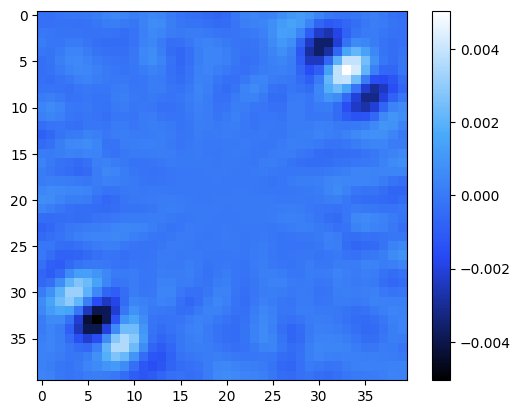

In [23]:
# Generate the correlation map
module = CorrelationMapModule(n_data_in='data_norm', n_template_in='temp_norm', n_image_out='imag_corr')
pipeline.add_module(module)

# Run pipeline with all modules we have added so far
pipeline.run()

# Get the correlation map from the image resource
imag_corr = pipeline.get_resource('imag_corr').get_image(as_numpy=True)

# Plot the image
plt.imshow(imag_corr, cmap=cmap_blue)
plt.colorbar()
plt.show()

### Extract the Planetary Spectrum

We now extract the planetary spectrum and coordinates from our data using a (numerical) maximum likelihood estimation. This will take a few seconds to run.

In [24]:
module = MLParameterEstimationModule(
    n_setup_in='setup',
    n_data_in='data_norm',
    n_template_in='temp_norm',
    n_transformation_in='norm',
    n_planet_params_in='params_init',
    n_planet_params_out='params_ml',
)
pipeline.add_module(module)
pipeline.run()

Performing numerical MLE...
Done


Finally, we plot the extracted flux and corresponding uncertainties:

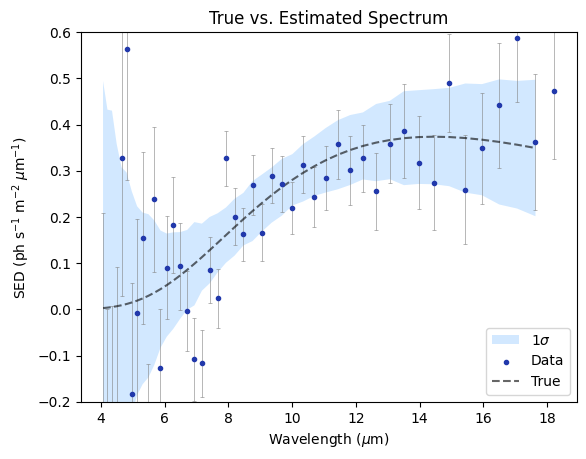

In [25]:
# Get the initial (input) parameters so we can plot the input spectrum (spectral energy distribution; SED) as a reference
params_init = pipeline.get_resource('params_init')
sed_init = params_init.params[0].sed.cpu().numpy()[:-1]  # Convert to numpy array from a torch Tensor
sed_init /= 1e6  # Convert to ph s-1 m-2 um-1
wavelengths = params_init.params[0].sed_wavelength_bin_centers.cpu().numpy()  # Convert to Torch tensor
wavelengths *= 1e6  # Convert from m to um

# Get the estimated parameters
params_ml = pipeline.get_resource('params_ml')
sed_estimated = params_ml.params[0].sed.cpu().numpy()
sed_estimated /= 1e6  # Convert to ph s-1 m-2 um-1
sed_err_low = params_ml.params[0].sed_err_low / 1e6
sed_err_high = params_ml.params[0].sed_err_high / 1e6

# Plot everything
yerr = np.stack([sed_err_low, sed_err_high])
plt.errorbar(
    wavelengths,
    sed_estimated,
    yerr=yerr,
    fmt='none',
    ecolor='gray',
    alpha=0.8,
    zorder=1,
    capsize=1.5,
    capthick=0.5,
    linewidth=0.5
)
plt.fill_between(
    wavelengths[:-1],
    np.array(sed_init) - np.array(sed_err_low)[:-1],
    np.array(sed_init) + np.array(sed_err_high)[:-1],
    color='dodgerblue',
    edgecolor=None,
    lw=0,
    alpha=0.2,
    label='1$\sigma$',
    zorder=0
)
plt.scatter(wavelengths, sed_estimated, label='Data', color="xkcd:sapphire", zorder=2, marker='.')
plt.plot(wavelengths[:-1], sed_init, label='True', linestyle='dashed', color='black', alpha=0.6, zorder=1)
plt.title('True vs. Estimated Spectrum')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SED (ph s$^{-1}$ m$^{-2}$ $\mu$m$^{-1}$)')
plt.ylim(-0.2, 0.6)
plt.legend()
plt.show()